# Beta Variational AutoEncoder

Model adopted from Keras VAE implementation "Convolutional Variational AutoEncoder (VAE) trained on MNIST digits" by [fchollet](https://twitter.com/fchollet)  
https://keras.io/examples/generative/vae/

## Setups

In [ ]:
!pip install tensorflow-datasets==4.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.segmentation import slic
from skimage.measure import regionprops
import warnings
warnings.filterwarnings("ignore")

## Beta-VAE model

### Sampler
Used to sample dataponts in latent space by using mean and std provided by encoder


In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


### Encoder
Default parameters are taken from Keras example.  

In [ ]:
def encoder(input_shape=[28,28], filters=[64,64], kernels=[3,5], strides=[2,2], hidden_dim=300, latent_dim=16):
  input = keras.Input(shape=(input_shape[0], input_shape[1], 1))
  x = input
  for i in range(len(filters)):
    x = layers.Conv2D(filters=filters[i], kernel_size=kernels[i], strides=strides[i], padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

  x = layers.Flatten()(x)
  x = layers.Dense(hidden_dim)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  z_mean = layers.Dense(latent_dim, name="z_mean")(x)  #encoder encodes to mean and var=std^2. We sample random vector from these values
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  enc = keras.Model(input, [z_mean, z_log_var, z], name="encoder")
  return enc

encoder().summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   640         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 14, 14, 64)   0           ['batch_normalization[0][0]

### Decoder

In [ ]:
def decoder(latent_dim=16, hidden=[7,7], filters=[64, 64], kernels=[5,3], strides=[2,2]):
  input = keras.Input(shape=(latent_dim,))
  x = layers.Dense(hidden[0]*hidden[1]*filters[0])(input)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Reshape((hidden[0], hidden[1], filters[0]))(x)

  for i in range(len(filters)):
    x = layers.Conv2DTranspose(filters=filters[i], kernel_size=kernels[i], strides=strides[i], padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

  x = layers.Conv2DTranspose(1, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  output = layers.Activation('sigmoid')(x)

  dec = keras.Model(input, output, name="decoder")
  return dec

decoder().summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              53312     
                                                                 
 batch_normalization_3 (Batc  (None, 3136)             12544     
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       102464    
 nspose)                                                   

### bVAE model
Keras VAE example is slightly modified here to include parameter beta see  
https://github.com/sootlasten/beta-vae/blob/master/bvae-tf/models.py  
https://github.com/alecGraves/BVAE-tf/blob/master/bvae/sample_layer.py


In [ ]:
class bVAE(keras.Model):
    def __init__(self, beta, encoder, decoder, **kwargs):
        super(bVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -self.beta*0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## bVAE on MNIST

### MNIST dataset
We adopt MNIST dataset from tensorflow datasets collection

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

In [ ]:
aa = np.expand_dims(x_train, -1).astype("float32") / 255

len(aa)

60000

### Beta = 1
We use default parameters here. We also save model weights during training  
https://www.tensorflow.org/tutorials/keras/save_and_load

In [ ]:
beta = 0.001
vae1 = bVAE(beta, encoder(), decoder())
vae1.compile(optimizer=keras.optimizers.Adam())  #learning rate can be varied too


checkpoint_path = "checkpoints/mnist_beta1/latest_checkpoint"
callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                           save_weights_only=True,
                                           verbose=1)  #Creates callback that saves the model's weights

vae1.fit(mnist_digits, epochs=5, batch_size=128, callbacks=[callback]) #epochs=30

Epoch 1/5
547/547 [==============================] - ETA: 0s - loss: 211.3053 - reconstruction_loss: 145.7514 - kl_loss: 0.1624
Epoch 1: saving model to checkpoints/mnist_beta1/latest_checkpoint
547/547 [==============================] - 120s 217ms/step - loss: 211.1860 - reconstruction_loss: 145.7514 - kl_loss: 0.1624
Epoch 2/5
 49/547 [=>............................] - ETA: 1:45 - loss: 81.3495 - reconstruction_loss: 80.3608 - kl_loss: 0.1803

KeyboardInterrupt: ignored

#### Reconstruction vs original

In [ ]:
def reconstructed_image(img, model, text,cmap='binary'): #img is usual batch of gray image (None, .., .., 1)
  #img0_ = tf.reshape(img,[1,img.shape[0],img.shape[1],1]) #we need input in the shape (None, 128,192,1)
  #encoded = model.encoder.predict(img0_)
  #decoded =  model.decoder.predict(encoded[2])  #0 element on mean, 2 element is sampled x,y in latent space
  #reconstruction = decoded.reshape(decoded.shape[1],decoded.shape[2])
  encoded = model.encoder.predict(img)
  decoded =  model.decoder.predict(encoded[2])  #0 element on mean, 2 element is sampled x,y in latent space

  plt.rcParams['font.size'] = 15
  fig, panel = plt.subplots(decoded.shape[0], 2, figsize=(10,20))
  for i in range(decoded.shape[0]):
    panel[i,0].imshow(img[i,:,:,0],cmap=cmap)
    panel[i,0].axis('off')
    #panel[i,1].imshow(reconstruction[i,:,:,0],cmap=cmap)
    panel[i,1].imshow(decoded[i,:,:,0],cmap=cmap)
    panel[i,1].axis('off')

  panel[0,0].set_title(f'original')  
  panel[0,1].set_title(f'reconstruction')
  fig.suptitle(text)
  #fig.tight_layout()
  plt.show()

img = x_train[1]
reconstructed_image(img, vae1, 'beta=1')

NameError: ignored

#### Restoring model from file

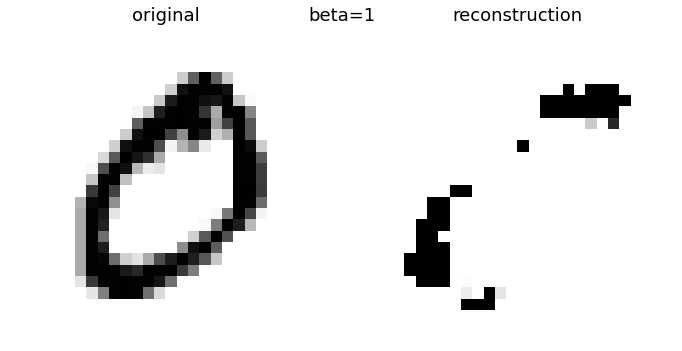

In [ ]:
vae1_ = bVAE(beta, encoder(), decoder())
vae1_.compile(optimizer=keras.optimizers.Adam())
vae1_.load_weights(checkpoint_path)

reconstructed_image(img, vae1_, 'beta=1')

#### Grid of sampled digits

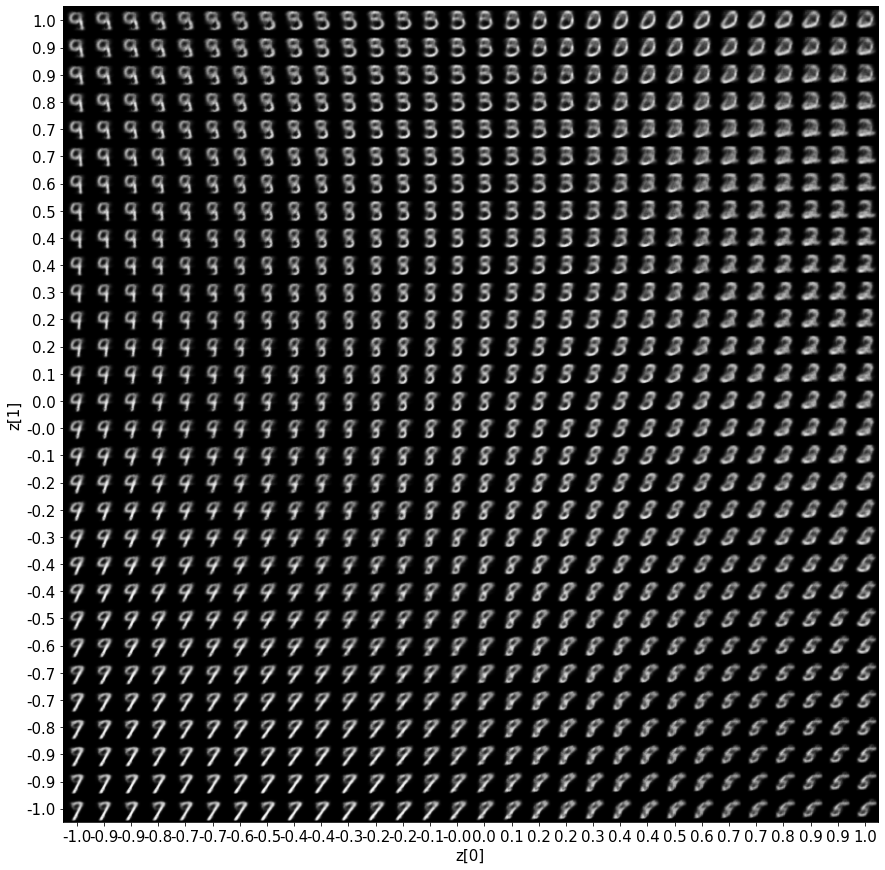

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)  #decode from 2d point in latent space 
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="binary_r")
    plt.show()

plot_latent_space(vae1)

Our latent space is 2dim, i.e. we have only two features there as x and y coordinates. We see from image above that x coordinate (z[0]) seems to reflect tilt of digit (see last row), while y coordinate (z[1]) is about inner structure of digit.

#### Latent-space means distribution for classes

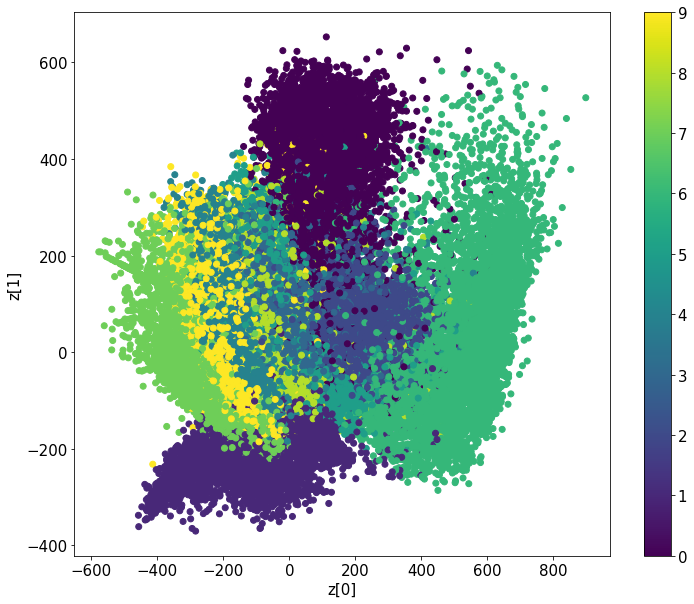

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(vae1, x_train, y_train)

### Beta = 30

In [ ]:
beta = 30

vae30 = bVAE(beta, encoder(), decoder())
vae30.compile(optimizer=keras.optimizers.Adam()) 
vae30.fit(mnist_digits, epochs=5, batch_size=128) 

Epoch 1/5
547/547 [==============================] - 106s 189ms/step - loss: 257.2243 - reconstruction_loss: 219.8147 - kl_loss: 0.0282
Epoch 2/5
547/547 [==============================] - 110s 202ms/step - loss: 206.3072 - reconstruction_loss: 206.2751 - kl_loss: 1.3901e-04
Epoch 3/5
547/547 [==============================] - 133s 242ms/step - loss: 206.2174 - reconstruction_loss: 206.2293 - kl_loss: 6.8244e-05
Epoch 4/5
547/547 [==============================] - 104s 190ms/step - loss: 206.0951 - reconstruction_loss: 206.1768 - kl_loss: 3.9352e-05
Epoch 5/5
547/547 [==============================] - 104s 190ms/step - loss: 206.2725 - reconstruction_loss: 206.1910 - kl_loss: 3.9663e-05


#### Reconstruction vs original

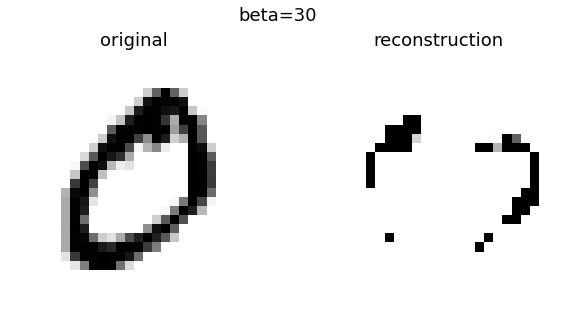

In [ ]:
#img = x_train[1]
reconstructed_image(img, vae30, 'beta=30')

#### Latent-space means distribution for classes

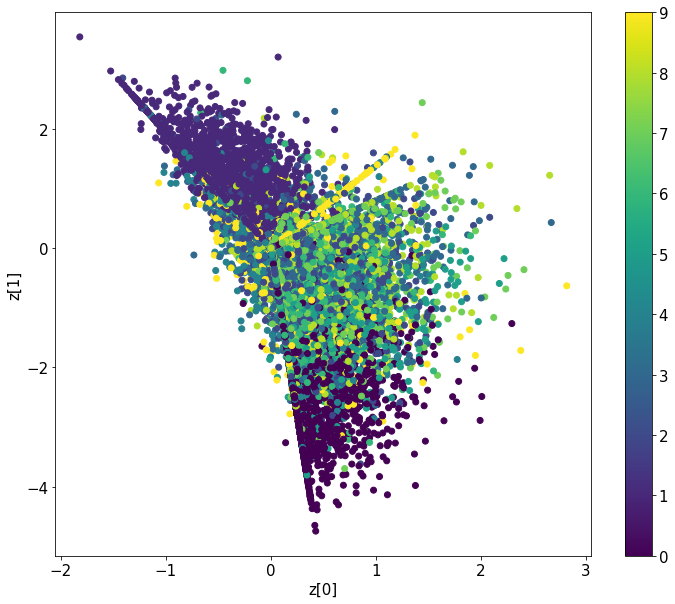

In [ ]:
plot_label_clusters(vae30, x_train, y_train)

### Beta = 0.001

In [ ]:
beta = 0.001
vae001 = bVAE(beta, encoder(), decoder())
vae001.compile(optimizer=keras.optimizers.Adam()) 
vae001.fit(mnist_digits, epochs=5, batch_size=128) 

Epoch 1/5
547/547 [==============================] - 132s 237ms/step - loss: 243.7584 - reconstruction_loss: 197.6374 - kl_loss: 0.0568
Epoch 2/5
547/547 [==============================] - 111s 203ms/step - loss: 166.4156 - reconstruction_loss: 164.1722 - kl_loss: 0.0880
Epoch 3/5
547/547 [==============================] - 103s 189ms/step - loss: 158.9038 - reconstruction_loss: 157.5801 - kl_loss: 0.0816
Epoch 4/5
547/547 [==============================] - 109s 200ms/step - loss: 153.6419 - reconstruction_loss: 153.1520 - kl_loss: 0.0765
Epoch 5/5
547/547 [==============================] - 102s 187ms/step - loss: 151.5128 - reconstruction_loss: 150.7162 - kl_loss: 0.0716


#### Latent-space means distribution for classes

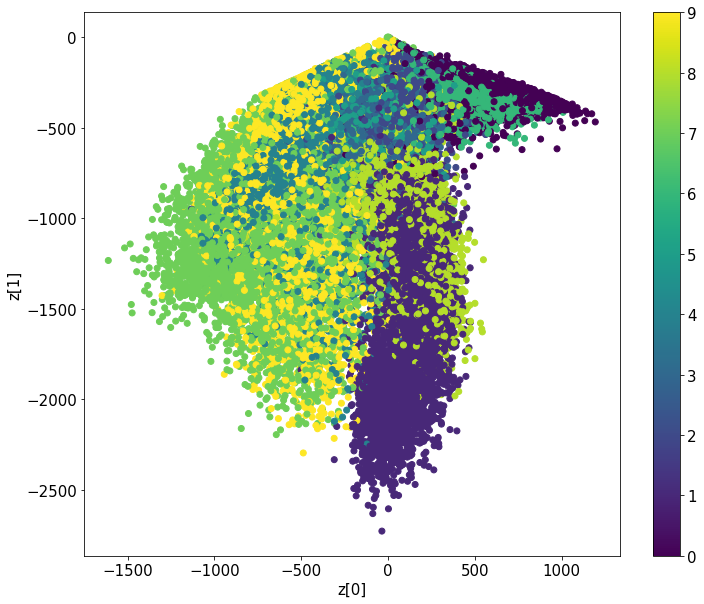

In [ ]:
plot_label_clusters(vae001, x_train, y_train)

## bVAE on CARS196

### CARS196 dataset

Working with tf datasets, see  
https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb#scrollTo=tzQTCUkAfe9R

on splits and determinism  
https://www.tensorflow.org/datasets/splits  
https://www.tensorflow.org/datasets/determinism#determinism_when_reading


In [ ]:
cars0_train, cars0_test = tfds.load('cars196', split=['train+test[:90%]','test[90%:]'], as_supervised=False, shuffle_files=True)
#cars0 = cars0_train.concatenate(cars0_test)
print(len(tfds.as_numpy(cars0_train)),len(tfds.as_numpy(cars0_test)))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cars196/2.0.1.incomplete5351HM/cars196-train.tfrecord*...:   0%|          …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cars196/2.0.1.incomplete5351HM/cars196-test.tfrecord*...:   0%|          |…

Dataset cars196 downloaded and prepared to /root/tensorflow_datasets/cars196/2.0.1. Subsequent calls will reuse this data.
15381 804


### Image parameters

In [ ]:
data = tfds.as_numpy(cars0_train)

In [ ]:
shapes = []
for d in data:
    img = d['image']
    shapes +=[[img.shape[0],img.shape[1]]]
len(shapes)

15381

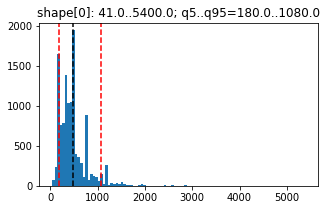

In [ ]:
def plot_param(points,text):
  plt.figure(figsize=(5, 3))
  plt.rcParams['font.size'] = 10
  plt.hist(points, bins=100)
  plt.axvline(x=np.mean(points),c='k',ls='--')
  plt.axvline(x=np.quantile(points,0.05),c='r',ls='--')
  plt.axvline(x=np.quantile(points,0.95),c='r',ls='--')
  plt.title(text + f": {np.min(points):.1f}..{np.max(points):.1f}; q5..q95={np.quantile(points,0.05):.1f}..{np.quantile(points,0.95):.1f}" )
  plt.show()

plot_param(np.array(shapes)[:,0],'shape[0]')

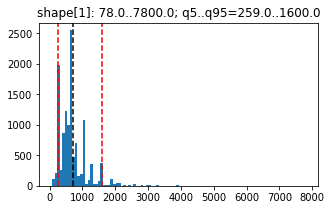

In [ ]:
plot_param(np.array(shapes)[:,1],'shape[1]')

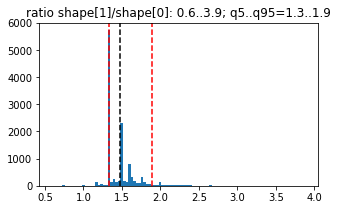

In [ ]:
plot_param(np.array(shapes)[:,1]/np.array(shapes)[:,0],'ratio shape[1]/shape[0]')

How to deal with variate size input images?  
https://wandb.ai/ayush-thakur/dl-question-bank/reports/How-to-Handle-Images-of-Different-Sizes-in-a-Convolutional-Neural-Network--VmlldzoyMDk3NzQ

- resize
- crop
- leave as is since CNN does not care unless numpy-sensitive layers appear (eg Flatten)
- GlobalPooling
- PyramidPooling  
https://www.tensorflow.org/addons/api_docs/python/tfa/layers/SpatialPyramidPooling2D  
https://peace195.github.io/spatial-pyramid-pooling/  
https://programming.vip/docs/61af99d6920d4.html  
https://stackoverflow.com/questions/65199018/keras-spatial-pyramid-pooling-not-working-problem-in-training  

- Feature extraction like PCA, LDA. But in this case we loose patterns on extracted 'images' so no reason to use convolutions and one has to apply dense layers only. Thus, NN architecture is changing in this approach.

### Image preprocessing ideas

#### Boundary Box

Abount bbox format  
https://stackoverflow.com/questions/48915003/get-the-bounding-box-coordinates-in-the-tensorflow-object-detection-api-tutorial

H x W: 600 X 800
boundary box: [0.31166667 0.06125    0.75166667 0.8475    ]


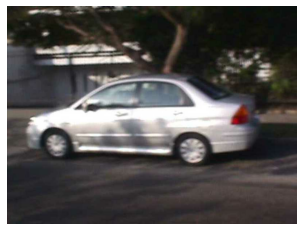

In [ ]:
for i,d in enumerate(data):
  img = d['image']
  bbox = d['bbox']
  label = d['label']
  if i == 5: break

h,w = img.shape[:2]
print(f'H x W: {h} X {w}')
print(f'boundary box: {bbox}')
ymin, xmin, ymax, xmax = bbox
left, right, top, bottom = xmin*w, xmax*w, ymax*h, ymin*h

plt.imshow(img)
plt.plot([left,left,right,right,left],[top,bottom,bottom,top,top],c='r')
plt.title(f"class {label}")
plt.axis('off')
plt.show()

#### Resize

https://scikit-image.org/docs/stable/auto_examples/transform/plot_rescale.html


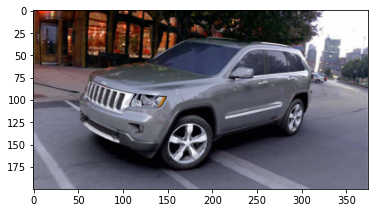

In [ ]:
ysize=200
def im_resize(image,y_size):
  return resize(image, (y_size, int(y_size*image.shape[1]/image.shape[0])), anti_aliasing=True)

img_r = im_resize(img,ysize)
plt.imshow(img_r)
plt.show()

#### From RGB to GRAY
https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_gray.html


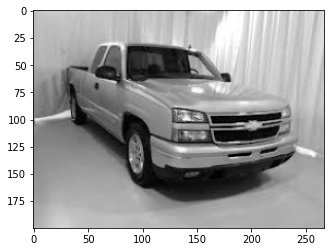

In [ ]:
img_g = rgb2gray(img_r)
plt.imshow(img_g,cmap='binary_r')

#### Color segmentation

https://stackoverflow.com/questions/53155771/average-colour-of-slic-superpixel


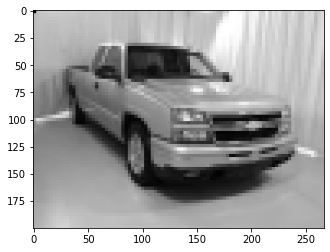

In [ ]:
def color_segmentation(image, number_segments=5000):
  out = np.zeros(image.shape)
  segments = slic(image, n_segments=number_segments, enforce_connectivity=True)  #basically Kmeans
  regions = regionprops(segments, intensity_image=image)

  for r in regions:
    r_c = r.coords
    for i in range(r_c.shape[0]):
      out[r_c[i][0],r_c[i][1]] = r.mean_intensity 
  return out

img_s = color_segmentation(img_g)
plt.imshow(img_s,cmap='binary_r')
plt.show()

#### Crop

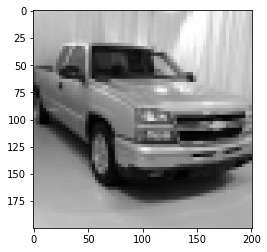

In [ ]:
xcrop = 200
def im_crop(image,x_crop): 
  x = int(image.shape[1]/2)
  dx = int(x_crop/2)
  if image.shape[1]>=x_crop: return image[:,x-dx:x+dx+1]  #crop around image center
  else: return []

img_cr = im_crop(img_s,xcrop)
plt.imshow(img_cr,cmap='binary_r')
plt.show()

### Image preproessing for blog

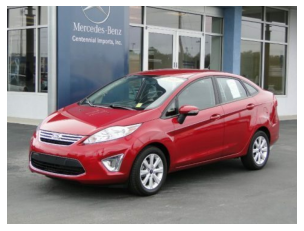

In [ ]:
for i in cars0_train:
  im = i['image']
  bb = i['bbox']
  break

img = tfds.as_numpy(im)
plt.imshow(img)
plt.axis('off');

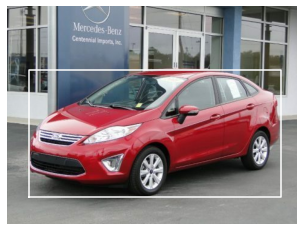

In [ ]:
h,w = img.shape[:2]
box = tfds.as_numpy(bb)
ymin, xmin, ymax, xmax = box
left, right, top, bottom = xmin*w, xmax*w, ymax*h, ymin*h

plt.imshow(img)
plt.plot([left,left,right,right,left],[top,bottom,bottom,top,top],c='white')
plt.axis('off');

In [ ]:
scaled_box = box * [h, w, h, w]
[int(i) for i in scaled_box]

[104, 36, 315, 453]

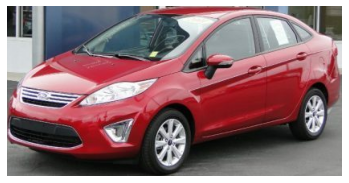

In [ ]:
scaled_box = box * [h, w, h, w]
ymin, xmin, ymax, xmax = [int(i) for i in scaled_box]
box_width = xmax - xmin
box_height = ymax - ymin
cropped = tf.image.crop_to_bounding_box(im, ymin, xmin, box_height, box_width)
plt.imshow(tfds.as_numpy(cropped))
plt.axis('off');

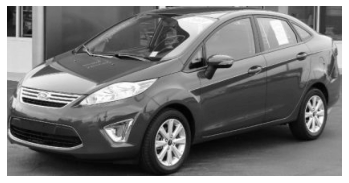

In [ ]:
rgb = tf.image.rgb_to_grayscale(cropped)
plt.imshow(tfds.as_numpy(rgb)[:,:,0],cmap='binary_r')
plt.axis('off');

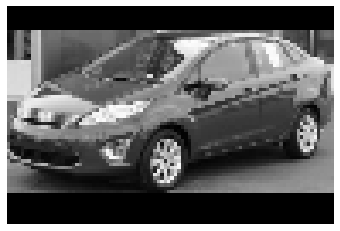

In [ ]:
with_pad = tf.image.resize_with_pad(rgb, input_shape[0], input_shape[1])
plt.imshow(tfds.as_numpy(with_pad)[:,:,0],cmap='binary_r')
plt.axis('off');

### TensorFlow preprocessing

https://www.kaggle.com/code/shiyuanwang0929/module-11-class-1-cars/notebook
https://stackoverflow.com/questions/67629889/tensorflow-image-crop-from-bounding-box

We use
- BBox cut
- RGG to GRAY
- Resize with padding
- MinMax scaler

In [ ]:
input_shape = [64,96]
batch_size = 128

In [ ]:
def tf_preprocessing(tensor_row): #this has to be implemented by using tf functions only
  image = tensor_row['image']
  height, width = tf.unstack(tf.shape(image)[:2])
  box = tensor_row['bbox']
  scaled_box = box * [height, width, height, width]
  ymin, xmin, ymax, xmax = tf.unstack(tf.cast(scaled_box, tf.int32))
  box_width = xmax - xmin
  box_height = ymax - ymin
  image = tf.image.crop_to_bounding_box(image, ymin, xmin, box_height, box_width)
  image = tf.image.rgb_to_grayscale(image)
  image = tf.image.resize_with_pad(image, input_shape[0], input_shape[1])
  image = image/255.0
  return image

In [ ]:
#cars = cars0_train.map(tf_preprocessing)
cars = cars0_train.map(lambda x: tf_preprocessing(x))
#cars = cars0.map(lambda x: {'image': tf.image.rgb_to_grayscale(x['image'])} )
#cars = cars.map(lambda x: {'image': tf.image.resize_with_pad(x['image'], input_shape[0], input_shape[1])} )
#cars = cars.map(lambda x: x['image']/255.0 ) #minmax normalization

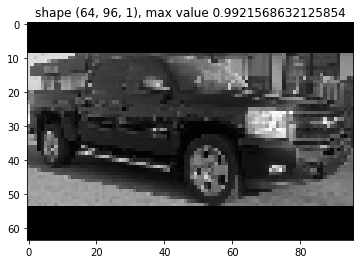

In [ ]:
for i,r in enumerate(cars):
  im = r
  if i ==3: break

plt.imshow(im[:,:,0],cmap='binary_r')
plt.title(f'shape {im.shape}, max value {np.max(im)}')
plt.show()

In [ ]:
def augmentation(tensor_row):
  image = tensor_row['image']
  height, width = tf.unstack(tf.shape(image)[:2])
  box = tensor_row['bbox']
  scaled_box = box * [height, width, height, width]
  ymin, xmin, ymax, xmax = tf.unstack(tf.cast(scaled_box, tf.int32))
  box_width = xmax - xmin
  box_height = ymax - ymin
  image = tf.image.crop_to_bounding_box(image, ymin, xmin, box_height, box_width)
  image = tf.image.rgb_to_grayscale(image)
  image = tf.image.resize_with_pad(image, input_shape[0], input_shape[1])
  image = tf.image.flip_left_right(image)
  image = image/255.0
  return image

cars_au = cars0_train.map(augmentation)
cars = cars.concatenate(cars_au)

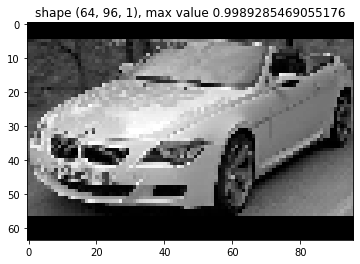

In [ ]:
for i,r in enumerate(cars_au):
  im = r
  if i ==3: break

plt.imshow(im[:,:,0],cmap='binary_r')
plt.title(f'shape {im.shape}, max value {np.max(im)}')
plt.show()

In [ ]:
len(tfds.as_numpy(cars))

30762

Prepare dataset for using in model (makes batches etc)  
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

In [ ]:
cars = cars.cache().shuffle(len(shapes)+1).batch(batch_size).prefetch(buffer_size=3)  #model.fit wont work without this step

### Setting up model

- first learn smaller features (ie small filter kernels at start)

In [ ]:
beta = 0.001

#encoder
filters = [64,64,64,64]
kernels=[3,5,7,9] 
strides=[2,2,2,2]
hidden_dim = 512
latent_dim = 48

#decoder
hidden = [4,6]

epochs = 30

In [ ]:
#import sys

output = []
output += [f'input_shape = {input_shape}']
output += [f'batch_size = {batch_size:.0f}']
output += [f'beta = {beta:.3f}']
output += [f'filters = {filters}']
output += [f'kernels = {kernels}']
output += [f'strides = {strides}']
output += [f'hidden_dim = {hidden_dim:.0f}']
output += [f'latent_dim = {latent_dim:.0f}']
output += [f'hidden = {hidden}']
output += [f'epochs = {epochs:.0f}']
output += ['\nloss  reconstruction_loss  kl_loss']
#for i in range(len(history.history['loss'])):
#    output += [f"{history.history['loss'][i]:.3f} {history.history['reconstruction_loss'][i]:.3f} {history.history['kl_loss'][i]:.3f}"]


file = open("bvae_output.output", 'w')
for o in output: file.write(o+'\n')  #we remove comma after last json object in collection
file.close()

#sys.stdout=open("bvae_output.output","w")  #opens file to write output there
#for o in output: print(o)
#sys.stdout.close()


In [ ]:
enc = encoder(input_shape=input_shape, filters=filters, kernels=kernels, strides=strides, hidden_dim=hidden_dim, latent_dim=latent_dim)
enc.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 96, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 48, 64)   640         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 32, 48, 64)  256         ['conv2d_2[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_7 (Activation)      (None, 32, 48, 64)   0           ['batch_normalization_7[0][

In [ ]:
dec = decoder(latent_dim=latent_dim, hidden=hidden, filters=filters[-1::-1], kernels=kernels[-1::-1], strides=strides[-1::-1])
dec.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48)]              0         
                                                                 
 dense_3 (Dense)             (None, 1536)              75264     
                                                                 
 batch_normalization_12 (Bat  (None, 1536)             6144      
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 1536)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 6, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 12, 64)        331840    
 ranspose)                                                 

### Architecture visualisation

In [ ]:
!pip install visualkeras pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [ ]:
!fc-list

/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf: Liberation Sans Narrow:style=Italic
/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf: Liberation Sans:style=Regular
/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf: Liberation Mono:style=Bold Italic
/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf: Liberation Serif:style=Italic
/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf: Liberation Mono:style=Bold
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf: Liberation Sans Narrow:style=Regular
/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf: Liberation Serif:style=Bold
/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf: Liberation Mono:style=Regular
/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf: Liberation Sans:style=Italic
/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf: Liberation Serif:style=Bold Italic
/usr/share/fonts/truet

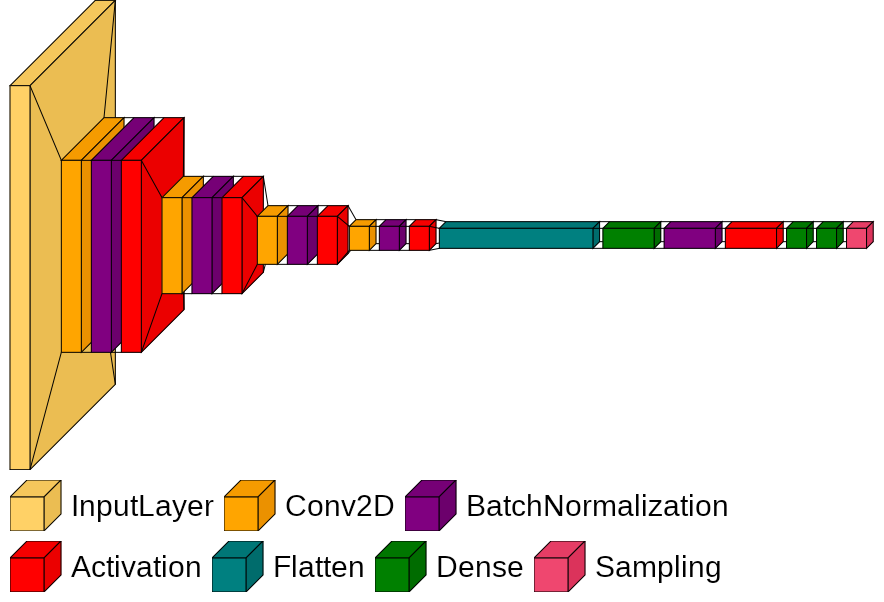

In [ ]:
import visualkeras
from PIL import ImageFont
font = ImageFont.truetype("LiberationSans-Regular.ttf", 30)

#from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D

from collections import defaultdict

color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = 'orange'
color_map[layers.Input]['fill'] = 'gray'
color_map[layers.BatchNormalization]['fill'] = 'purple'
color_map[layers.Activation]['fill'] = 'red'
color_map[layers.Dense]['fill'] = 'green'
color_map[layers.Flatten]['fill'] = 'teal'
#color_map[layers.Sampling]['fill'] = 'black'
color_map[layers.Reshape]['fill'] = 'blue'
color_map[layers.Conv2DTranspose]['fill'] = 'cyan'


visualkeras.layered_view(enc, legend=True, font=font, to_file='enc.png',color_map=color_map)

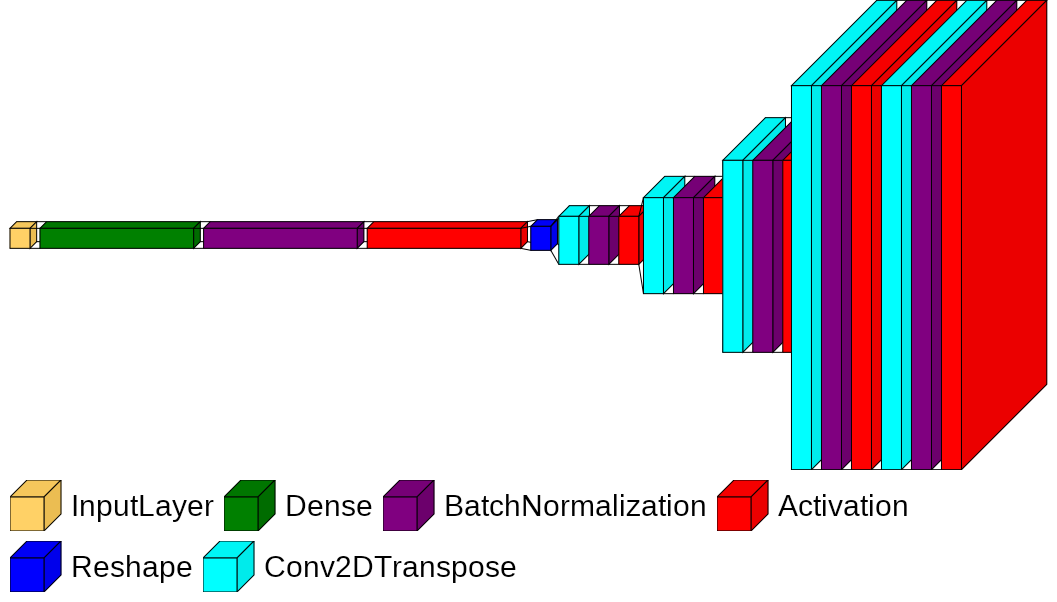

In [ ]:
visualkeras.layered_view(dec, legend=True, font=font, to_file='dec.png',color_map=color_map)

### Train bVAE on cars196

In [ ]:
vae = bVAE(beta, enc, dec)
vae.compile(optimizer=keras.optimizers.Adam())  

checkpoint_path = "checkpoints/cars_beta001/latest_checkpoint"
callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                           save_weights_only=True,
                                           verbose=1)  #Creates callback that saves the model's weights

history = vae.fit(cars, epochs=epochs, batch_size=batch_size, callbacks=[callback]) 

Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 3663.5006 - reconstruction_loss: 3461.3420 - kl_loss: 0.5294
Epoch 1: saving model to checkpoints/cars_beta001/latest_checkpoint
96/96 [==============================] - 578s 5s/step - loss: 3661.4220 - reconstruction_loss: 3461.3420 - kl_loss: 0.5294
Epoch 2/30
96/96 [==============================] - ETA: 0s - loss: 3207.4453 - reconstruction_loss: 3174.4500 - kl_loss: 1.0634
Epoch 2: saving model to checkpoints/cars_beta001/latest_checkpoint
96/96 [==============================] - 495s 5s/step - loss: 3207.1160 - reconstruction_loss: 3174.4500 - kl_loss: 1.0634
Epoch 3/30
96/96 [==============================] - ETA: 0s - loss: 3077.5725 - reconstruction_loss: 3040.7473 - kl_loss: 0.9764
Epoch 3: saving model to checkpoints/cars_beta001/latest_checkpoint
96/96 [==============================] - 495s 5s/step - loss: 3077.2029 - reconstruction_loss: 3040.7473 - kl_loss: 0.9764
Epoch 4/30
96/96 [======================

14:15-18:35

In [ ]:
history.history

{'kl_loss': [0.5293721556663513,
  1.0633946657180786,
  0.9764164090156555,
  0.9126166701316833,
  0.908534586429596,
  0.87493497133255,
  0.7515139579772949,
  0.7434539198875427,
  0.6924512386322021,
  0.7197715640068054,
  0.6780839562416077,
  0.6914636492729187,
  0.6461998224258423,
  0.6689278483390808,
  0.676133930683136,
  0.6362869739532471,
  0.6169576644897461,
  0.6714043021202087,
  0.5832261443138123,
  0.6268897652626038,
  0.6246326565742493,
  0.5949524641036987,
  0.621001660823822,
  0.5936142802238464,
  0.6168749332427979,
  0.5934644341468811,
  0.6036569476127625,
  0.594930112361908,
  0.6103970408439636,
  0.5952692627906799],
 'loss': [3461.87109375,
  3175.512451171875,
  3041.7236328125,
  2935.059814453125,
  2883.523681640625,
  2847.705810546875,
  2839.5517578125,
  2817.212646484375,
  2824.623779296875,
  2798.252685546875,
  2789.664306640625,
  2776.632568359375,
  2774.751220703125,
  2759.465087890625,
  2741.376220703125,
  2749.038818359375

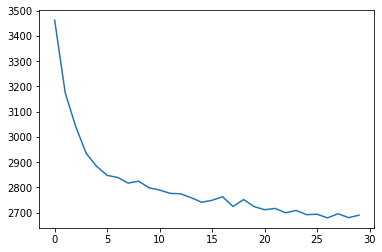

In [ ]:
plt.plot(history.history['loss'])

### Reconstructions

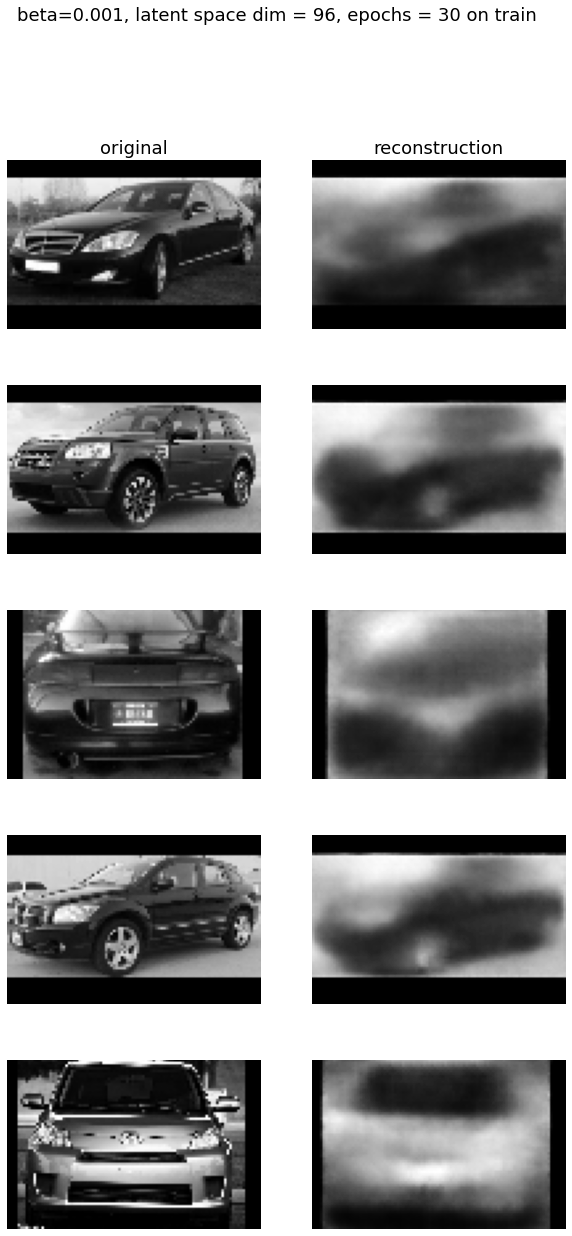

In [ ]:
for i,r in enumerate(cars):
  im = r[:5]
  break

reconstructed_image(im, vae, f'beta={beta}, latent space dim = {latent_dim}, epochs = {epochs} on train',cmap='binary_r')

In [ ]:
testcars = cars0_test.map(tf_preprocessing)
testcars = testcars.cache().shuffle(len(shapes)+1).batch(batch_size).prefetch(buffer_size=3)

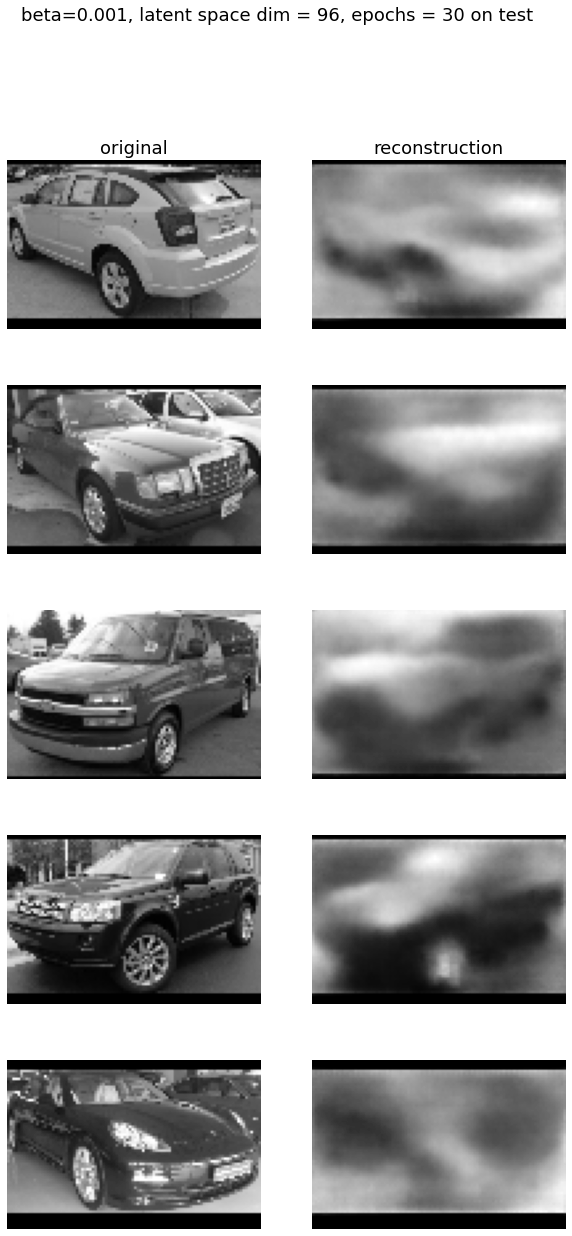

In [ ]:
for i,r in enumerate(testcars):
  im = r[:5]
  break

reconstructed_image(im, vae, f'beta={beta}, latent space dim = {latent_dim}, epochs = {epochs} on test',cmap='binary_r')

In [ ]:
encoded = vae.encoder.predict(img0_)
decoded =  vae.decoder.predict(encoded[2])  #0 element on mean, 2 element is sampled x,y in latent space
reconstruction = decoded.reshape(decoded.shape[1], decoded.shape[2])

def plot_reconstructions(img,reconstruction,text):
  plt.rcParams['font.size'] = 15
  fig, panel = plt.subplots(1, 2, figsize=(10,5))
  panel[0].imshow(img,cmap='binary_r')
  panel[0].set_title(f'original')
  panel[0].axis('off')
  panel[1].imshow(reconstruction,cmap='binary_r')
  panel[1].set_title(f'reconstruction')
  panel[1].axis('off')
  #panel[1].text(-170, -20, text, fontsize = 20)
  fig.suptitle(text)
  plt.show()

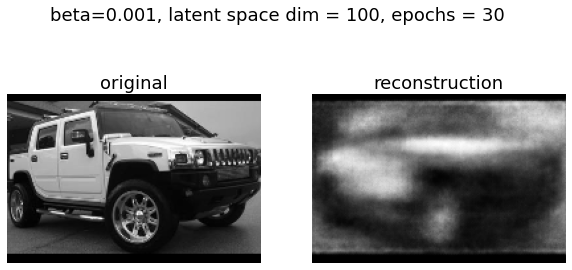

In [ ]:
plot_reconstructions(img0,reconstruction,f'beta={beta}, latent={latent_dim}, shape={img0.shape}, epochs={epochs}'))

In [ ]:
plot_reconstructions(img0,reconstruction,f'beta={beta}, latent space dim = {latent_dim}, epochs = {epochs}')

In [ ]:
plot_reconstructions(img0,reconstruction,f'beta={beta}, latent space dim = {latent_dim}, epochs = {epochs}')

In [ ]:
plot_reconstructions(img0,reconstruction,f'beta={beta}, latent space dim = {latent_dim}, epochs = {epochs}')